In [1]:
import watermarking, utilities, attacks, parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# =========================
# Helper Functions
# =========================
def bits_to_watermark_image(bits, watermark_size):
    """Convert extracted bits back to watermark image"""
    bits_2d = np.array(bits).reshape(watermark_size, watermark_size)
    pixels = (bits_2d * 255).astype(np.uint8)
    watermark_img = Image.fromarray(pixels, mode='L')
    return watermark_img

# =========================
# Configuration
# =========================
HOST_IMAGES_PATH = "dataset/host/"
WATERMARK_PATH = "dataset/watermark_32x32.png"
OUTPUT_PATH = "dataset/analysis/"
NUM_IMAGES = 10

# Create organized output directories
WATERMARKED_DIR = "dataset/watermarked/"
JPEG_Q75_DIR = "dataset/jpeg_q75/"
CROPPED_DIR = "dataset/cropped/"
ROTATION_1DG_DIR = "dataset/rotation_1dg/"
GAUSS_NOISE_DIR = "dataset/gauss_noise/"
UNIFORM_NOISE_DIR = "dataset/uniform_noise/"
WHATSAPP_DIR = "dataset/whatsapp/"
AFTER_CROPPED_WHATSAPP = "dataset/after_cropped_whatsapp/"
BEFORE_CROPPED_WHATSAPP = "dataset/before_cropped_whatsapp/"

# Create watermark extraction subdirectories
WATERMARKED_WM_DIR = f"{WATERMARKED_DIR}watermark/"
JPEG_Q75_WM_DIR = f"{JPEG_Q75_DIR}watermark/"
CROPPED_WM_DIR = f"{CROPPED_DIR}watermark/"
ROTATION_1DG_WM_DIR = f"{ROTATION_1DG_DIR}watermark/"
GAUSS_NOISE_WM_DIR = f"{GAUSS_NOISE_DIR}watermark/"
UNIFORM_NOISE_WM_DIR = f"{UNIFORM_NOISE_DIR}watermark/"
WHATSAPP_WM_DIR = f"{WHATSAPP_DIR}watermark/"
AFTER_CROPPED_WHATSAPP_WM_DIR = f"{AFTER_CROPPED_WHATSAPP}watermark/"
BEFORE_CROPPED_WHATSAPP_WM_DIR = f"{BEFORE_CROPPED_WHATSAPP}watermark/"

# Create all directories if they don't exist
for directory in [
    OUTPUT_PATH, WATERMARKED_DIR, JPEG_Q75_DIR, CROPPED_DIR, ROTATION_1DG_DIR,
    GAUSS_NOISE_DIR, UNIFORM_NOISE_DIR, WHATSAPP_DIR, AFTER_CROPPED_WHATSAPP,
    BEFORE_CROPPED_WHATSAPP, WATERMARKED_WM_DIR, JPEG_Q75_WM_DIR, CROPPED_WM_DIR,
    ROTATION_1DG_WM_DIR, GAUSS_NOISE_WM_DIR, UNIFORM_NOISE_WM_DIR, WHATSAPP_WM_DIR,
    AFTER_CROPPED_WHATSAPP_WM_DIR, BEFORE_CROPPED_WHATSAPP_WM_DIR
]:
    os.makedirs(directory, exist_ok=True)

# =========================
# Analysis Functions
# =========================
def run_single_image_analysis(image_idx):
    """Run complete analysis for a single image"""
    print(f"\n=== Analyzing Image {image_idx} ===")
    
    # Paths for organized storage
    host_path = f"{HOST_IMAGES_PATH}image{image_idx}.jpg"
    watermarked_path = f"{WATERMARKED_DIR}watermarked_{image_idx}.png"
    whatsapp_path = f"{WHATSAPP_DIR}whatsapp_{image_idx}.jpg"
    jpeg_path = f"{JPEG_Q75_DIR}jpeg_q75_{image_idx}.jpg"
    crop_path = f"{CROPPED_DIR}cropped_{image_idx}.png"
    rot_path = f"{ROTATION_1DG_DIR}rotation_1dg_{image_idx}.png"
    gauss_path = f"{GAUSS_NOISE_DIR}gauss_noise_{image_idx}.png"
    uniform_path = f"{UNIFORM_NOISE_DIR}uniform_noise_{image_idx}.png"
    after_cropped_whatsapp_path = f"{AFTER_CROPPED_WHATSAPP}after_cropped_whatsapp_{image_idx}.jpg"
    before_cropped_whatsapp_path = f"{BEFORE_CROPPED_WHATSAPP}before_cropped_whatsapp_{image_idx}.jpg"

    # Check if host image exists
    if not os.path.exists(host_path):
        print(f"Host image {host_path} not found!")
        return None
    
    try:
        # 1. Load host image and watermark
        host_pil = Image.open(host_path).convert("RGB")
        watermark_pil = Image.open(WATERMARK_PATH).convert("RGBA")
        
        # Convert host to YCbCr and get Y channel
        Y, Cb, Cr = utilities.to_ycbcr_arrays(host_pil)
        
        # Prepare watermark bits
        wm_bits_true = utilities.prepare_watermark_bits(watermark_pil, parameters.WATERMARK_SIZE)
        
        # Embed watermark
        Y_wm = watermarking.embed_watermark(Y, wm_bits_true)
        
        # Convert back to RGB and save in watermarked directory
        watermarked_pil = utilities.from_ycbcr_arrays(Y_wm, Cb, Cr)
        watermarked_pil.save(watermarked_path)
        
        # Convert to numpy arrays for PSNR calculation
        host_u8 = np.array(host_pil, dtype=np.uint8)
        watermarked_u8 = np.array(watermarked_pil, dtype=np.uint8)
        
        # Calculate PSNR for embedding
        psnr_embed = utilities.psnr(host_u8, watermarked_u8)
        
        # 2. Extract from clean watermarked image (baseline) - BOTH ALGORITHMS
        bits_clean_std = watermarking.extract_watermark(Y_wm, parameters.WATERMARK_SIZE)
        bits_clean_enh = watermarking.extract_watermark_enhanced(Y_wm, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks as images
        clean_wm_std = bits_to_watermark_image(bits_clean_std, parameters.WATERMARK_SIZE)
        clean_wm_enh = bits_to_watermark_image(bits_clean_enh, parameters.WATERMARK_SIZE)
        clean_wm_std.save(f"{WATERMARKED_WM_DIR}extracted_std_{image_idx}.png")
        clean_wm_enh.save(f"{WATERMARKED_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_clean_std = utilities.bit_error_rate(wm_bits_true, bits_clean_std)
        ncc_clean_std = utilities.normalized_cross_correlation(wm_bits_true, bits_clean_std)
        
        ber_clean_enh = utilities.bit_error_rate(wm_bits_true, bits_clean_enh)
        ncc_clean_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_clean_enh)
        
        results = {
            'image_id': image_idx,
            'psnr_embed': psnr_embed,
            'clean_ber_std': ber_clean_std,
            'clean_ncc_std': ncc_clean_std,
            'clean_ber_enh': ber_clean_enh,
            'clean_ncc_enh': ncc_clean_enh
        }
        
        # 2b. Extract from WhatsApp watermarked image (baseline) - BOTH ALGORITHMS
        whatsapp_pil = Image.open(whatsapp_path).convert("RGB")
        whatsapp_u8 = np.array(whatsapp_pil, dtype=np.uint8)
        psnr_whatsapp = utilities.psnr(watermarked_u8, whatsapp_u8)

        Y_whatsapp, _, _ = utilities.to_ycbcr_arrays(whatsapp_pil)
        bits_whatsapp_std = watermarking.extract_watermark(Y_whatsapp, parameters.WATERMARK_SIZE)
        bits_whatsapp_enh = watermarking.extract_watermark_enhanced(Y_whatsapp, parameters.WATERMARK_SIZE)

        # Save extracted watermarks from WhatsApp images
        whatsapp_wm_std = bits_to_watermark_image(bits_whatsapp_std, parameters.WATERMARK_SIZE)
        whatsapp_wm_enh = bits_to_watermark_image(bits_whatsapp_enh, parameters.WATERMARK_SIZE)
        whatsapp_wm_std.save(f"{WHATSAPP_WM_DIR}extracted_std_{image_idx}.png")
        whatsapp_wm_enh.save(f"{WHATSAPP_WM_DIR}extracted_enh_{image_idx}.png")

        ber_whatsapp_std = utilities.bit_error_rate(wm_bits_true, bits_whatsapp_std)
        ncc_whatsapp_std = utilities.normalized_cross_correlation(wm_bits_true, bits_whatsapp_std)

        ber_whatsapp_enh = utilities.bit_error_rate(wm_bits_true, bits_whatsapp_enh)
        ncc_whatsapp_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_whatsapp_enh)

        results.update({
            'whatsapp_psnr': psnr_whatsapp,
            'whatsapp_ber_std': ber_whatsapp_std,
            'whatsapp_ncc_std': ncc_whatsapp_std,
            'whatsapp_ber_enh': ber_whatsapp_enh,
            'whatsapp_ncc_enh': ncc_whatsapp_enh
        })

        # 3. JPEG Compression Attack (Q=75) - BOTH ALGORITHMS
        attacks.jpeg_attack(watermarked_path, jpeg_path, quality=75)
        
        jpeg_pil = Image.open(jpeg_path).convert("RGB")
        jpeg_u8 = np.array(jpeg_pil, dtype=np.uint8)
        psnr_jpeg = utilities.psnr(watermarked_u8, jpeg_u8)
        
        Y_jpeg, _, _ = utilities.to_ycbcr_arrays(jpeg_pil)
        bits_jpeg_std = watermarking.extract_watermark(Y_jpeg, parameters.WATERMARK_SIZE)
        bits_jpeg_enh = watermarking.extract_watermark_enhanced(Y_jpeg, parameters.WATERMARK_SIZE)
        
        jpeg_wm_std = bits_to_watermark_image(bits_jpeg_std, parameters.WATERMARK_SIZE)
        jpeg_wm_enh = bits_to_watermark_image(bits_jpeg_enh, parameters.WATERMARK_SIZE)
        jpeg_wm_std.save(f"{JPEG_Q75_WM_DIR}extracted_std_{image_idx}.png")
        jpeg_wm_enh.save(f"{JPEG_Q75_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_jpeg_std = utilities.bit_error_rate(wm_bits_true, bits_jpeg_std)
        ncc_jpeg_std = utilities.normalized_cross_correlation(wm_bits_true, bits_jpeg_std)
        ber_jpeg_enh = utilities.bit_error_rate(wm_bits_true, bits_jpeg_enh)
        ncc_jpeg_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_jpeg_enh)

        results.update({
            'jpeg_psnr': psnr_jpeg,
            'jpeg_ber_std': ber_jpeg_std,
            'jpeg_ncc_std': ncc_jpeg_std,
            'jpeg_ber_enh': ber_jpeg_enh,
            'jpeg_ncc_enh': ncc_jpeg_enh
        })
        
        # 4. Cropping Attack (1 patch, 5% area) - BOTH ALGORITHMS
        crop_u8 = watermarked_u8.copy()
        attacks.crop_attack(crop_u8, area_ratio=0.05, num_patches=1, seed=42)
        crop_pil = Image.fromarray(crop_u8)
        crop_pil.save(crop_path)
        
        psnr_crop = utilities.psnr(watermarked_u8, crop_u8)
        
        Y_crop, _, _ = utilities.to_ycbcr_arrays(crop_pil)
        bits_crop_std = watermarking.extract_watermark(Y_crop, parameters.WATERMARK_SIZE)
        bits_crop_enh = watermarking.extract_watermark_enhanced(Y_crop, parameters.WATERMARK_SIZE)
        
        crop_wm_std = bits_to_watermark_image(bits_crop_std, parameters.WATERMARK_SIZE)
        crop_wm_enh = bits_to_watermark_image(bits_crop_enh, parameters.WATERMARK_SIZE)
        crop_wm_std.save(f"{CROPPED_WM_DIR}extracted_std_{image_idx}.png")
        crop_wm_enh.save(f"{CROPPED_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_crop_std = utilities.bit_error_rate(wm_bits_true, bits_crop_std)
        ncc_crop_std = utilities.normalized_cross_correlation(wm_bits_true, bits_crop_std)
        ber_crop_enh = utilities.bit_error_rate(wm_bits_true, bits_crop_enh)
        ncc_crop_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_crop_enh)

        results.update({
            'crop_psnr': psnr_crop,
            'crop_ber_std': ber_crop_std,
            'crop_ncc_std': ncc_crop_std,
            'crop_ber_enh': ber_crop_enh,
            'crop_ncc_enh': ncc_crop_enh
        })
        
        # 5. Rotation Attack (1 degree) - BOTH ALGORITHMS
        rot_pil = attacks.rotation_attack(watermarked_pil, angle=1.0)
        rot_pil.save(rot_path)
        
        rot_u8 = np.array(rot_pil, dtype=np.uint8)
        psnr_rot = utilities.psnr(watermarked_u8, rot_u8)
        
        Y_rot, _, _ = utilities.to_ycbcr_arrays(rot_pil)
        bits_rot_std = watermarking.extract_watermark(Y_rot, parameters.WATERMARK_SIZE)
        bits_rot_enh = watermarking.extract_watermark_enhanced(Y_rot, parameters.WATERMARK_SIZE)
        
        rot_wm_std = bits_to_watermark_image(bits_rot_std, parameters.WATERMARK_SIZE)
        rot_wm_enh = bits_to_watermark_image(bits_rot_enh, parameters.WATERMARK_SIZE)
        rot_wm_std.save(f"{ROTATION_1DG_WM_DIR}extracted_std_{image_idx}.png")
        rot_wm_enh.save(f"{ROTATION_1DG_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_rot_std = utilities.bit_error_rate(wm_bits_true, bits_rot_std)
        ncc_rot_std = utilities.normalized_cross_correlation(wm_bits_true, bits_rot_std)
        ber_rot_enh = utilities.bit_error_rate(wm_bits_true, bits_rot_enh)
        ncc_rot_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_rot_enh)

        results.update({
            'rot_psnr': psnr_rot,
            'rot_ber_std': ber_rot_std,
            'rot_ncc_std': ncc_rot_std,
            'rot_ber_enh': ber_rot_enh,
            'rot_ncc_enh': ncc_rot_enh
        })
        
        # 6. Gaussian Noise Attack (std=10) - BOTH ALGORITHMS
        gauss_u8 = attacks.gaussian_noise_attack(watermarked_u8.copy(), std=10, seed=42)
        gauss_pil = Image.fromarray(gauss_u8)
        gauss_pil.save(gauss_path)
        
        psnr_gauss = utilities.psnr(watermarked_u8, gauss_u8)
        
        Y_gauss, _, _ = utilities.to_ycbcr_arrays(gauss_pil)
        bits_gauss_std = watermarking.extract_watermark(Y_gauss, parameters.WATERMARK_SIZE)
        bits_gauss_enh = watermarking.extract_watermark_enhanced(Y_gauss, parameters.WATERMARK_SIZE)
        
        gauss_wm_std = bits_to_watermark_image(bits_gauss_std, parameters.WATERMARK_SIZE)
        gauss_wm_enh = bits_to_watermark_image(bits_gauss_enh, parameters.WATERMARK_SIZE)
        gauss_wm_std.save(f"{GAUSS_NOISE_WM_DIR}extracted_std_{image_idx}.png")
        gauss_wm_enh.save(f"{GAUSS_NOISE_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_gauss_std = utilities.bit_error_rate(wm_bits_true, bits_gauss_std)
        ncc_gauss_std = utilities.normalized_cross_correlation(wm_bits_true, bits_gauss_std)
        ber_gauss_enh = utilities.bit_error_rate(wm_bits_true, bits_gauss_enh)
        ncc_gauss_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_gauss_enh)

        results.update({
            'gauss_psnr': psnr_gauss,
            'gauss_ber_std': ber_gauss_std,
            'gauss_ncc_std': ncc_gauss_std,
            'gauss_ber_enh': ber_gauss_enh,
            'gauss_ncc_enh': ncc_gauss_enh
        })
        
        # 7. Uniform Noise Attack (intensity=20) - BOTH ALGORITHMS
        uniform_u8 = attacks.uniform_noise_attack(watermarked_u8.copy(), intensity=20, seed=42)
        uniform_pil = Image.fromarray(uniform_u8)
        uniform_pil.save(uniform_path)
        
        psnr_uniform = utilities.psnr(watermarked_u8, uniform_u8)
        
        Y_uniform, _, _ = utilities.to_ycbcr_arrays(uniform_pil)
        bits_uniform_std = watermarking.extract_watermark(Y_uniform, parameters.WATERMARK_SIZE)
        bits_uniform_enh = watermarking.extract_watermark_enhanced(Y_uniform, parameters.WATERMARK_SIZE)

        uniform_wm_std = bits_to_watermark_image(bits_uniform_std, parameters.WATERMARK_SIZE)
        uniform_wm_enh = bits_to_watermark_image(bits_uniform_enh, parameters.WATERMARK_SIZE)
        uniform_wm_std.save(f"{UNIFORM_NOISE_WM_DIR}extracted_std_{image_idx}.png")
        uniform_wm_enh.save(f"{UNIFORM_NOISE_WM_DIR}extracted_enh_{image_idx}.png")

        ber_uniform_std = utilities.bit_error_rate(wm_bits_true, bits_uniform_std)
        ncc_uniform_std = utilities.normalized_cross_correlation(wm_bits_true, bits_uniform_std)
        ber_uniform_enh = utilities.bit_error_rate(wm_bits_true, bits_uniform_enh)
        ncc_uniform_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_uniform_enh)

        results.update({
            'uniform_psnr': psnr_uniform,
            'uniform_ber_std': ber_uniform_std,
            'uniform_ncc_std': ncc_uniform_std,
            'uniform_ber_enh': ber_uniform_enh,
            'uniform_ncc_enh': ncc_uniform_enh
        })

        # 8. AFTER-CROPPED → WhatsApp (files already exist) - BOTH ALGORITHMS
        acw_pil = Image.open(after_cropped_whatsapp_path).convert("RGB")
        acw_u8 = np.array(acw_pil, dtype=np.uint8)
        psnr_after_cw = utilities.psnr(watermarked_u8, acw_u8)

        Y_after_cw, _, _ = utilities.to_ycbcr_arrays(acw_pil)
        bits_after_cw_std = watermarking.extract_watermark(Y_after_cw, parameters.WATERMARK_SIZE)
        bits_after_cw_enh = watermarking.extract_watermark_enhanced(Y_after_cw, parameters.WATERMARK_SIZE)

        acw_wm_std = bits_to_watermark_image(bits_after_cw_std, parameters.WATERMARK_SIZE)
        acw_wm_enh = bits_to_watermark_image(bits_after_cw_enh, parameters.WATERMARK_SIZE)
        acw_wm_std.save(f"{AFTER_CROPPED_WHATSAPP_WM_DIR}extracted_std_{image_idx}.png")
        acw_wm_enh.save(f"{AFTER_CROPPED_WHATSAPP_WM_DIR}extracted_enh_{image_idx}.png")

        ber_after_cw_std = utilities.bit_error_rate(wm_bits_true, bits_after_cw_std)
        ncc_after_cw_std = utilities.normalized_cross_correlation(wm_bits_true, bits_after_cw_std)
        ber_after_cw_enh = utilities.bit_error_rate(wm_bits_true, bits_after_cw_enh)
        ncc_after_cw_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_after_cw_enh)

        results.update({
            'after_cw_psnr': psnr_after_cw,
            'after_cw_ber_std': ber_after_cw_std,
            'after_cw_ncc_std': ncc_after_cw_std,
            'after_cw_ber_enh': ber_after_cw_enh,
            'after_cw_ncc_enh': ncc_after_cw_enh
        })

        # 9. BEFORE-CROPPED (crop WhatsApp image with same settings) - BOTH ALGORITHMS
        bcw_u8 = whatsapp_u8.copy()
        attacks.crop_attack(bcw_u8, area_ratio=0.05, num_patches=1, seed=42)  # same as #4
        bcw_pil = Image.fromarray(bcw_u8)
        bcw_pil.save(before_cropped_whatsapp_path)

        psnr_before_cw = utilities.psnr(watermarked_u8, bcw_u8)

        Y_before_cw, _, _ = utilities.to_ycbcr_arrays(bcw_pil)
        bits_before_cw_std = watermarking.extract_watermark(Y_before_cw, parameters.WATERMARK_SIZE)
        bits_before_cw_enh = watermarking.extract_watermark_enhanced(Y_before_cw, parameters.WATERMARK_SIZE)

        bcw_wm_std = bits_to_watermark_image(bits_before_cw_std, parameters.WATERMARK_SIZE)
        bcw_wm_enh = bits_to_watermark_image(bits_before_cw_enh, parameters.WATERMARK_SIZE)
        bcw_wm_std.save(f"{BEFORE_CROPPED_WHATSAPP_WM_DIR}extracted_std_{image_idx}.png")
        bcw_wm_enh.save(f"{BEFORE_CROPPED_WHATSAPP_WM_DIR}extracted_enh_{image_idx}.png")

        ber_before_cw_std = utilities.bit_error_rate(wm_bits_true, bits_before_cw_std)
        ncc_before_cw_std = utilities.normalized_cross_correlation(wm_bits_true, bits_before_cw_std)
        ber_before_cw_enh = utilities.bit_error_rate(wm_bits_true, bits_before_cw_enh)
        ncc_before_cw_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_before_cw_enh)

        results.update({
            'before_cw_psnr': psnr_before_cw,
            'before_cw_ber_std': ber_before_cw_std,
            'before_cw_ncc_std': ncc_before_cw_std,
            'before_cw_ber_enh': ber_before_cw_enh,
            'before_cw_ncc_enh': ncc_before_cw_enh
        })

        return results

    except Exception as e:
        print(f"Error processing image {image_idx}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =========================
# Main Analysis Loop
# =========================
all_results = []
for i in range(1, NUM_IMAGES + 1):
    result = run_single_image_analysis(i)
    if result is not None:
        all_results.append(result)
print("Analysis complete.")


=== Analyzing Image 1 ===


C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_5776\1013394586.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  watermark_img = Image.fromarray(pixels, mode='L')



=== Analyzing Image 2 ===

=== Analyzing Image 3 ===

=== Analyzing Image 4 ===

=== Analyzing Image 5 ===

=== Analyzing Image 6 ===

=== Analyzing Image 7 ===

=== Analyzing Image 8 ===

=== Analyzing Image 9 ===

=== Analyzing Image 10 ===
Analysis complete.


In [2]:
# =========================
# Results Analysis
# =========================
# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)

# Save detailed results to CSV
df.to_csv(f"{OUTPUT_PATH}detailed_results.csv", index=False)

# Show PSNR

In [3]:
psnr_cols = ['image_id', 'psnr_embed']
df[psnr_cols]

,image_id,psnr_embed
0,1,34.340170
1,2,32.765549
2,3,32.722399
3,4,34.185261
4,5,32.156277
5,6,32.594341
6,7,33.257504
7,8,33.475877
8,9,32.461083
9,10,33.224431


# Show only Standard Algorithm BER columns

In [4]:
ber_std_cols = ['image_id', 'clean_ber_std', 'whatsapp_ber_std', 'after_cw_ber_std', 'before_cw_ber_std', 'jpeg_ber_std', 'crop_ber_std', 'rot_ber_std', 'gauss_ber_std', 'uniform_ber_std']
df[ber_std_cols]

,image_id,clean_ber_std,whatsapp_ber_std,after_cw_ber_std,before_cw_ber_std,jpeg_ber_std,crop_ber_std,rot_ber_std,gauss_ber_std,uniform_ber_std
0,1,0.0,0.000000,0.043945,0.044922,0.000977,0.043945,0.514648,0.002930,0.002930
1,2,0.0,0.000000,0.051758,0.051758,0.000000,0.052734,0.596680,0.000977,0.002930
2,3,0.0,0.000000,0.020508,0.019531,0.000000,0.020508,0.581055,0.001953,0.008789
3,4,0.0,0.000000,0.041016,0.040039,0.000000,0.033203,0.561523,0.000000,0.000977
4,5,0.0,0.000000,0.054688,0.054688,0.002930,0.043945,0.519531,0.000977,0.003906
5,6,0.0,0.000000,0.020508,0.021484,0.000977,0.019531,0.550781,0.000977,0.003906
6,7,0.0,0.000000,0.052734,0.053711,0.000000,0.053711,0.631836,0.000977,0.002930
7,8,0.0,0.000977,0.036133,0.037109,0.000977,0.030273,0.518555,0.001953,0.005859
8,9,0.0,0.000000,0.052734,0.053711,0.000977,0.043945,0.518555,0.000000,0.000977
9,10,0.0,0.000000,0.039062,0.039062,0.000000,0.038086,0.563477,0.000000,0.000000


# Show only Enhanced Algorithm BER columns

In [5]:
ber_enh_cols = ['image_id', 'clean_ber_enh', 'whatsapp_ber_enh', 'after_cw_ber_enh', 'before_cw_ber_enh', 'jpeg_ber_enh', 'crop_ber_enh', 'rot_ber_enh', 'gauss_ber_enh', 'uniform_ber_enh']
df[ber_enh_cols]

,image_id,clean_ber_enh,whatsapp_ber_enh,after_cw_ber_enh,before_cw_ber_enh,jpeg_ber_enh,crop_ber_enh,rot_ber_enh,gauss_ber_enh,uniform_ber_enh
0,1,0.0,0.000000,0.043945,0.044922,0.000977,0.043945,0.006836,0.002930,0.002930
1,2,0.0,0.000000,0.051758,0.051758,0.000000,0.052734,0.129883,0.000977,0.002930
2,3,0.0,0.000000,0.020508,0.019531,0.000000,0.020508,0.125977,0.001953,0.008789
3,4,0.0,0.000000,0.041016,0.040039,0.000000,0.033203,0.077148,0.000000,0.000977
4,5,0.0,0.000000,0.054688,0.054688,0.002930,0.043945,0.103516,0.000977,0.003906
5,6,0.0,0.000000,0.020508,0.021484,0.000977,0.019531,0.203125,0.000977,0.003906
6,7,0.0,0.000000,0.052734,0.053711,0.000000,0.053711,0.032227,0.000977,0.002930
7,8,0.0,0.000977,0.036133,0.037109,0.000977,0.030273,0.034180,0.001953,0.005859
8,9,0.0,0.000000,0.052734,0.053711,0.000977,0.043945,0.147461,0.000000,0.000977
9,10,0.0,0.000000,0.039062,0.039062,0.000000,0.038086,0.052734,0.000000,0.000000


# Show only Standard Algorithm NCC columns

In [6]:
ncc_std_cols = ['image_id', 'clean_ncc_std', 'whatsapp_ncc_std', 'after_cw_ncc_std', 'before_cw_ncc_std', 'jpeg_ncc_std', 'crop_ncc_std', 'rot_ncc_std', 'gauss_ncc_std', 'uniform_ncc_std']
df[ncc_std_cols]

,image_id,clean_ncc_std,whatsapp_ncc_std,after_cw_ncc_std,before_cw_ncc_std,jpeg_ncc_std,crop_ncc_std,rot_ncc_std,gauss_ncc_std,uniform_ncc_std
0,1,1.0,1.000000,0.975426,0.974873,0.999461,0.975426,0.657632,0.998386,0.998386
1,2,1.0,1.000000,0.970992,0.970992,1.000000,0.970437,0.583955,0.999460,0.998381
2,3,1.0,1.000000,0.988608,0.989154,1.000000,0.988608,0.598476,0.998923,0.995162
3,4,1.0,1.000000,0.977084,0.977636,1.000000,0.981490,0.616300,1.000000,0.999461
4,5,1.0,1.000000,0.969325,0.969325,0.998381,0.975426,0.652841,0.999461,0.997849
5,6,1.0,1.000000,0.988608,0.988063,0.999460,0.989154,0.625778,0.999461,0.997849
6,7,1.0,1.000000,0.970437,0.969881,1.000000,0.969881,0.549621,0.999461,0.998386
7,8,1.0,0.999461,0.979841,0.979290,0.999461,0.983137,0.653755,0.998923,0.996779
8,9,1.0,1.000000,0.970437,0.969881,0.999460,0.975426,0.653626,1.000000,0.999461
9,10,1.0,1.000000,0.978187,0.978187,1.000000,0.978738,0.614500,1.000000,1.000000


# Show only Enhanced Algorithm NCC columns

In [7]:
ncc_enh_cols = ['image_id', 'clean_ncc_enh', 'whatsapp_ncc_enh', 'after_cw_ncc_enh', 'before_cw_ncc_enh', 'jpeg_ncc_enh', 'crop_ncc_enh', 'rot_ncc_enh', 'gauss_ncc_enh', 'uniform_ncc_enh']
df[ncc_enh_cols]

,image_id,clean_ncc_enh,whatsapp_ncc_enh,after_cw_ncc_enh,before_cw_ncc_enh,jpeg_ncc_enh,crop_ncc_enh,rot_ncc_enh,gauss_ncc_enh,uniform_ncc_enh
0,1,1.0,1.000000,0.975426,0.974873,0.999461,0.975426,0.996218,0.998386,0.998386
1,2,1.0,1.000000,0.970992,0.970992,1.000000,0.970437,0.925487,0.999460,0.998381
2,3,1.0,1.000000,0.988608,0.989154,1.000000,0.988608,0.927818,0.998923,0.995162
3,4,1.0,1.000000,0.977084,0.977636,1.000000,0.981490,0.956441,1.000000,0.999461
4,5,1.0,1.000000,0.969325,0.969325,0.998381,0.975426,0.941091,0.999461,0.997849
5,6,1.0,1.000000,0.988608,0.988063,0.999460,0.989154,0.880696,0.999461,0.997849
6,7,1.0,1.000000,0.970437,0.969881,1.000000,0.969881,0.982040,0.999461,0.998386
7,8,1.0,0.999461,0.979841,0.979290,0.999461,0.983137,0.980940,0.998923,0.996779
8,9,1.0,1.000000,0.970437,0.969881,0.999460,0.975426,0.914937,1.000000,0.999461
9,10,1.0,1.000000,0.978187,0.978187,1.000000,0.978738,0.970437,1.000000,1.000000


# Show only Clean extraction results (both algorithms)

In [8]:
clean_cols = ['image_id', 'clean_ber_std', 'clean_ncc_std', 'clean_ber_enh', 'clean_ncc_enh']
df[clean_cols]

,image_id,clean_ber_std,clean_ncc_std,clean_ber_enh,clean_ncc_enh
0,1,0.0,1.0,0.0,1.0
1,2,0.0,1.0,0.0,1.0
2,3,0.0,1.0,0.0,1.0
3,4,0.0,1.0,0.0,1.0
4,5,0.0,1.0,0.0,1.0
5,6,0.0,1.0,0.0,1.0
6,7,0.0,1.0,0.0,1.0
7,8,0.0,1.0,0.0,1.0
8,9,0.0,1.0,0.0,1.0
9,10,0.0,1.0,0.0,1.0


# Show only JPEG attack results

In [9]:
jpeg_cols = ['image_id', 'jpeg_psnr', 'jpeg_ber_std', 'jpeg_ncc_std', 'jpeg_ber_enh', 'jpeg_ncc_enh']
df[jpeg_cols]

,image_id,jpeg_psnr,jpeg_ber_std,jpeg_ncc_std,jpeg_ber_enh,jpeg_ncc_enh
0,1,39.195396,0.000977,0.999461,0.000977,0.999461
1,2,39.969343,0.000000,1.000000,0.000000,1.000000
2,3,38.383412,0.000000,1.000000,0.000000,1.000000
3,4,38.854382,0.000000,1.000000,0.000000,1.000000
4,5,40.003856,0.002930,0.998381,0.002930,0.998381
5,6,38.397369,0.000977,0.999460,0.000977,0.999460
6,7,38.168702,0.000000,1.000000,0.000000,1.000000
7,8,37.493086,0.000977,0.999461,0.000977,0.999461
8,9,39.926431,0.000977,0.999460,0.000977,0.999460
9,10,39.325928,0.000000,1.000000,0.000000,1.000000


# Show only WhatsApp attack results

In [10]:
whatsapp_cols = ['image_id', 'whatsapp_psnr', 'whatsapp_ber_std', 'whatsapp_ncc_std', 'whatsapp_ber_enh', 'whatsapp_ncc_enh']
df[whatsapp_cols]

,image_id,whatsapp_psnr,whatsapp_ber_std,whatsapp_ncc_std,whatsapp_ber_enh,whatsapp_ncc_enh
0,1,43.871484,0.000000,1.000000,0.000000,1.000000
1,2,44.513554,0.000000,1.000000,0.000000,1.000000
2,3,43.267612,0.000000,1.000000,0.000000,1.000000
3,4,43.550166,0.000000,1.000000,0.000000,1.000000
4,5,45.029009,0.000000,1.000000,0.000000,1.000000
5,6,43.019232,0.000000,1.000000,0.000000,1.000000
6,7,41.628318,0.000000,1.000000,0.000000,1.000000
7,8,41.518173,0.000977,0.999461,0.000977,0.999461
8,9,44.416083,0.000000,1.000000,0.000000,1.000000
9,10,43.681105,0.000000,1.000000,0.000000,1.000000


# Show only Cropping Before WhatsApp attack results

In [11]:
after_cw_cols = ['image_id', 'after_cw_psnr', 'after_cw_ber_std', 'after_cw_ncc_std', 'after_cw_ber_enh', 'after_cw_ncc_enh']
df[after_cw_cols]

,image_id,after_cw_psnr,after_cw_ber_std,after_cw_ncc_std,after_cw_ber_enh,after_cw_ncc_enh
0,1,17.293922,0.043945,0.975426,0.043945,0.975426
1,2,19.251757,0.051758,0.970992,0.051758,0.970992
2,3,23.024590,0.020508,0.988608,0.020508,0.988608
3,4,19.651415,0.041016,0.977084,0.041016,0.977084
4,5,19.053139,0.054688,0.969325,0.054688,0.969325
5,6,22.503095,0.020508,0.988608,0.020508,0.988608
6,7,14.680548,0.052734,0.970437,0.052734,0.970437
7,8,21.032457,0.036133,0.979841,0.036133,0.979841
8,9,16.238118,0.052734,0.970437,0.052734,0.970437
9,10,19.239978,0.039062,0.978187,0.039062,0.978187


# Show only Cropping After WhatsApp attack results

In [12]:
before_cw_cols = ['image_id', 'before_cw_psnr', 'before_cw_ber_std', 'before_cw_ncc_std', 'before_cw_ber_enh', 'before_cw_ncc_enh']
df[before_cw_cols]

,image_id,before_cw_psnr,before_cw_ber_std,before_cw_ncc_std,before_cw_ber_enh,before_cw_ncc_enh
0,1,17.286281,0.044922,0.974873,0.044922,0.974873
1,2,19.247578,0.051758,0.970992,0.051758,0.970992
2,3,22.999637,0.019531,0.989154,0.019531,0.989154
3,4,19.640339,0.040039,0.977636,0.040039,0.977636
4,5,19.048194,0.054688,0.969325,0.054688,0.969325
5,6,22.493350,0.021484,0.988063,0.021484,0.988063
6,7,14.675063,0.053711,0.969881,0.053711,0.969881
7,8,21.019005,0.037109,0.979290,0.037109,0.979290
8,9,16.232786,0.053711,0.969881,0.053711,0.969881
9,10,19.232264,0.039062,0.978187,0.039062,0.978187


# Show only Cropping attack results

In [13]:
crop_cols = ['image_id', 'crop_psnr', 'crop_ber_std', 'crop_ncc_std', 'crop_ber_enh', 'crop_ncc_enh']
df[crop_cols]

,image_id,crop_psnr,crop_ber_std,crop_ncc_std,crop_ber_enh,crop_ncc_enh
0,1,17.295372,0.043945,0.975426,0.043945,0.975426
1,2,19.259892,0.052734,0.970437,0.052734,0.970437
2,3,23.038575,0.020508,0.988608,0.020508,0.988608
3,4,19.657245,0.033203,0.981490,0.033203,0.981490
4,5,19.058459,0.043945,0.975426,0.043945,0.975426
5,6,22.529882,0.019531,0.989154,0.019531,0.989154
6,7,14.683619,0.053711,0.969881,0.053711,0.969881
7,8,21.055015,0.030273,0.983137,0.030273,0.983137
8,9,16.238862,0.043945,0.975426,0.043945,0.975426
9,10,19.246997,0.038086,0.978738,0.038086,0.978738


# Show only Rotation attack results

In [14]:
rotation_cols = ['image_id', 'rot_psnr', 'rot_ber_std', 'rot_ncc_std', 'rot_ber_enh', 'rot_ncc_enh']
df[rotation_cols]

,image_id,rot_psnr,rot_ber_std,rot_ncc_std,rot_ber_enh,rot_ncc_enh
0,1,18.433921,0.514648,0.657632,0.006836,0.996218
1,2,17.630269,0.596680,0.583955,0.129883,0.925487
2,3,24.576749,0.581055,0.598476,0.125977,0.927818
3,4,19.756309,0.561523,0.616300,0.077148,0.956441
4,5,21.882425,0.519531,0.652841,0.103516,0.941091
5,6,23.111846,0.550781,0.625778,0.203125,0.880696
6,7,17.871949,0.631836,0.549621,0.032227,0.982040
7,8,17.371796,0.518555,0.653755,0.034180,0.980940
8,9,16.806705,0.518555,0.653626,0.147461,0.914937
9,10,19.610179,0.563477,0.614500,0.052734,0.970437


# Show only Gaussian Noise attack results

In [15]:
gauss_cols = ['image_id', 'gauss_psnr', 'gauss_ber_std', 'gauss_ncc_std', 'gauss_ber_enh', 'gauss_ncc_enh']
df[gauss_cols]

,image_id,gauss_psnr,gauss_ber_std,gauss_ncc_std,gauss_ber_enh,gauss_ncc_enh
0,1,28.127631,0.002930,0.998386,0.002930,0.998386
1,2,28.469691,0.000977,0.999460,0.000977,0.999460
2,3,28.353734,0.001953,0.998923,0.001953,0.998923
3,4,28.241246,0.000000,1.000000,0.000000,1.000000
4,5,28.139595,0.000977,0.999461,0.000977,0.999461
5,6,28.326868,0.000977,0.999461,0.000977,0.999461
6,7,28.350478,0.000977,0.999461,0.000977,0.999461
7,8,28.323876,0.001953,0.998923,0.001953,0.998923
8,9,28.260460,0.000000,1.000000,0.000000,1.000000
9,10,28.394580,0.000000,1.000000,0.000000,1.000000


# Show only Uniform Noise attack results

In [16]:
uniform_cols = ['image_id', 'uniform_psnr', 'uniform_ber_std', 'uniform_ncc_std', 'uniform_ber_enh', 'uniform_ncc_enh']
df[uniform_cols]

,image_id,uniform_psnr,uniform_ber_std,uniform_ncc_std,uniform_ber_enh,uniform_ncc_enh
0,1,26.894495,0.002930,0.998386,0.002930,0.998386
1,2,27.220469,0.002930,0.998381,0.002930,0.998381
2,3,27.117142,0.008789,0.995162,0.008789,0.995162
3,4,27.007039,0.000977,0.999461,0.000977,0.999461
4,5,26.900686,0.003906,0.997849,0.003906,0.997849
5,6,27.087395,0.003906,0.997849,0.003906,0.997849
6,7,27.110838,0.002930,0.998386,0.002930,0.998386
7,8,27.078746,0.005859,0.996779,0.005859,0.996779
8,9,27.023957,0.000977,0.999461,0.000977,0.999461
9,10,27.126229,0.000000,1.000000,0.000000,1.000000


# BER under Compression and Cropping (2nd Objective)

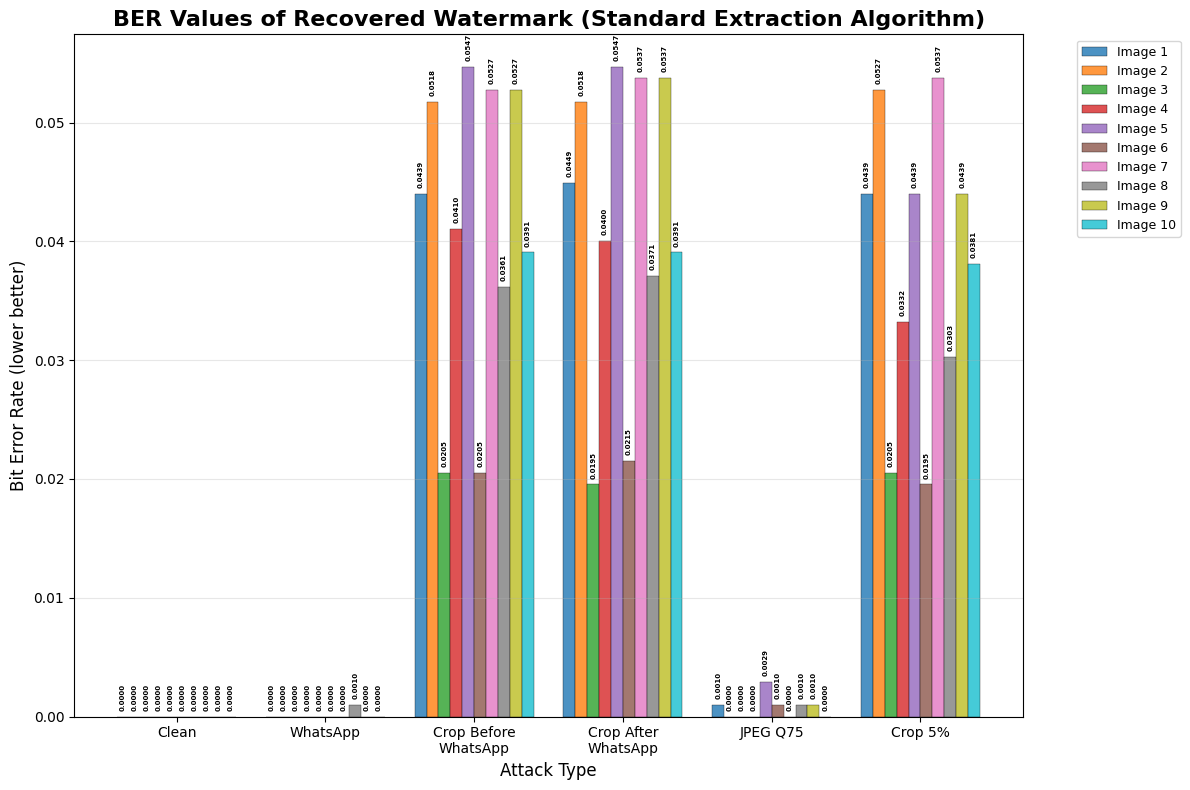

In [17]:
# ==========================================
# Bar chart - BER for whatsapp, crop_before_cw, crop_after_cw, jpeg, crop attacks with all 10 images (Standard extraction algorithm only)
# ==========================================
plt.figure(figsize=(12, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean','WhatsApp', 'Crop Before\nWhatsApp', 'Crop After\nWhatsApp', 'JPEG Q75', 'Crop 5%']
attack_keys = ['clean', 'whatsapp', 'after_cw', 'before_cw', 'jpeg', 'crop']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ber_values_per_image = []
    for attack_key in attack_keys:
        ber_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ber_std'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ber_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on ALL bars
    for bar, ber_val in zip(bars, ber_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f'{ber_val:.4f}', ha='center', va='bottom', fontsize=5, fontweight='bold',
                rotation=90)

plt.title(f'BER Values of Recovered Watermark (Standard Extraction Algorithm)', 
          fontsize=16, fontweight="bold")
plt.ylabel('Bit Error Rate (lower better)', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ber_2nd_obj_all_images_std.png", dpi=300, bbox_inches='tight')
plt.show()

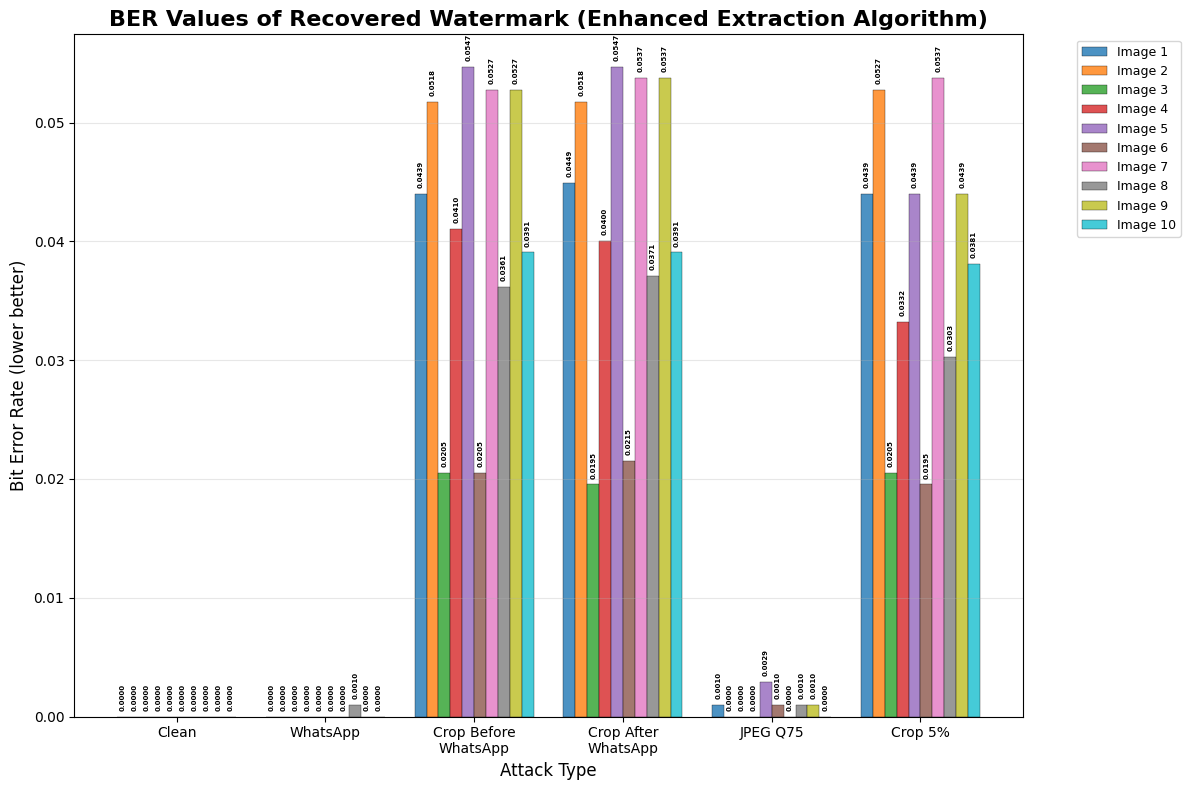

In [18]:
# ==========================================
# Bar chart - BER for whatsapp, crop_before_cw, crop_after_cw, jpeg, crop attacks with all 10 images (Enhanced extraction algorithm only)
# ==========================================
plt.figure(figsize=(12, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean','WhatsApp', 'Crop Before\nWhatsApp', 'Crop After\nWhatsApp', 'JPEG Q75', 'Crop 5%']
attack_keys = ['clean', 'whatsapp', 'after_cw', 'before_cw', 'jpeg', 'crop']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ber_values_per_image = []
    for attack_key in attack_keys:
        ber_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ber_enh'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ber_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on ALL bars
    for bar, ber_val in zip(bars, ber_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f'{ber_val:.4f}', ha='center', va='bottom', fontsize=5, fontweight='bold',
                rotation=90)

plt.title(f'BER Values of Recovered Watermark (Enhanced Extraction Algorithm)', 
          fontsize=16, fontweight="bold")
plt.ylabel('Bit Error Rate (lower better)', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ber_2nd_obj_all_images_enh.png", dpi=300, bbox_inches='tight')
plt.show()

# NCC under Compression and Cropping (2nd Objective)

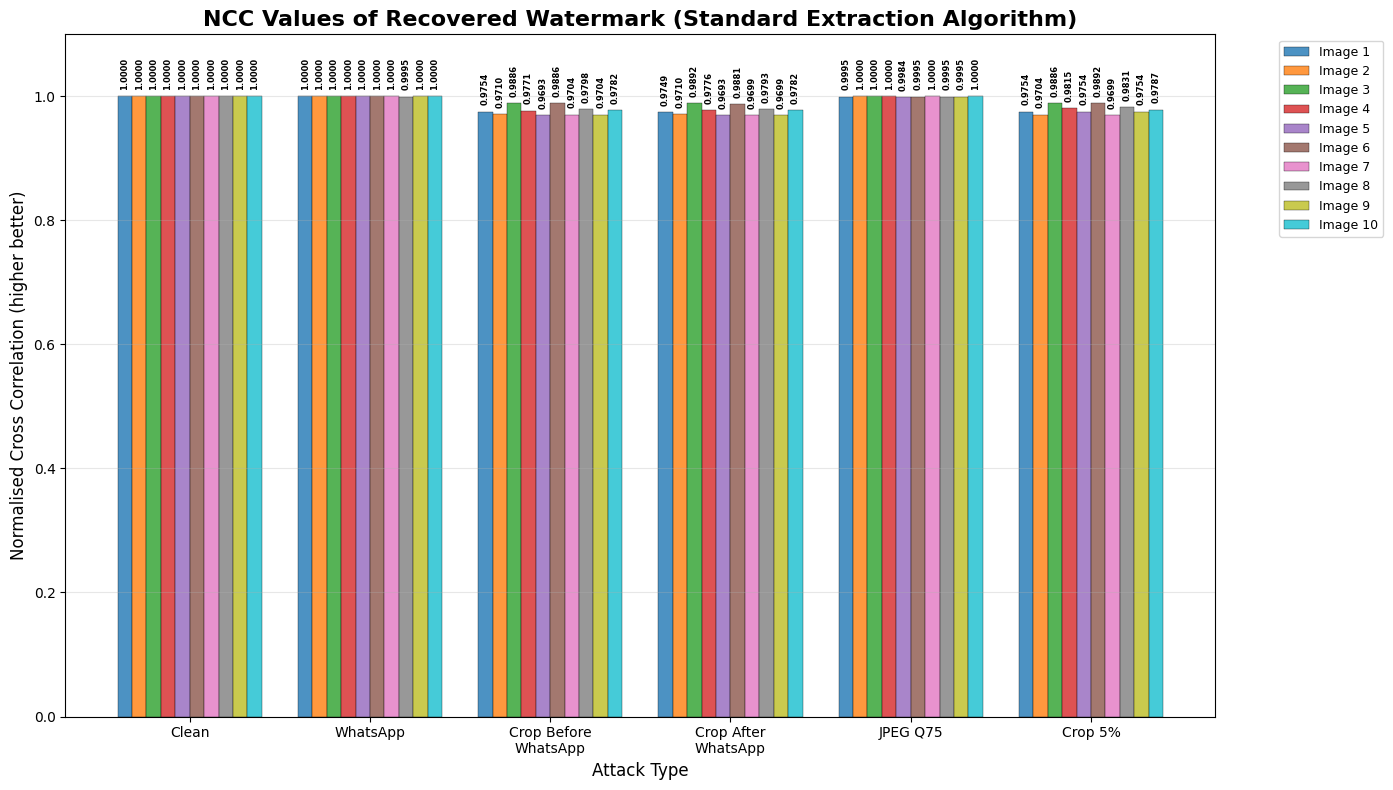

In [26]:
# ==========================================
# Bar chart - NCC for clean, whatsapp, crop_before_cw, crop_after_cw, jpeg, crop with all 10 images (Standard extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'WhatsApp', 'Crop Before\nWhatsApp', 'Crop After\nWhatsApp', 'JPEG Q75', 'Crop 5%']
attack_keys = ['clean', 'whatsapp', 'after_cw', 'before_cw', 'jpeg', 'crop']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ncc_values_per_image = []
    for attack_key in attack_keys:
        ncc_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ncc_std'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ncc_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on bars for low NCC values
    for bar, ncc_val in zip(bars, ncc_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ncc_val:.4f}', ha='center', va='bottom', fontsize=6, fontweight='bold',
                rotation=90)

plt.title('NCC Values of Recovered Watermark (Standard Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Normalised Cross Correlation (higher better)', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)  # Set y-axis limit for NCC values

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ncc_2obj_all_images_std.png", dpi=300, bbox_inches='tight')
plt.show()

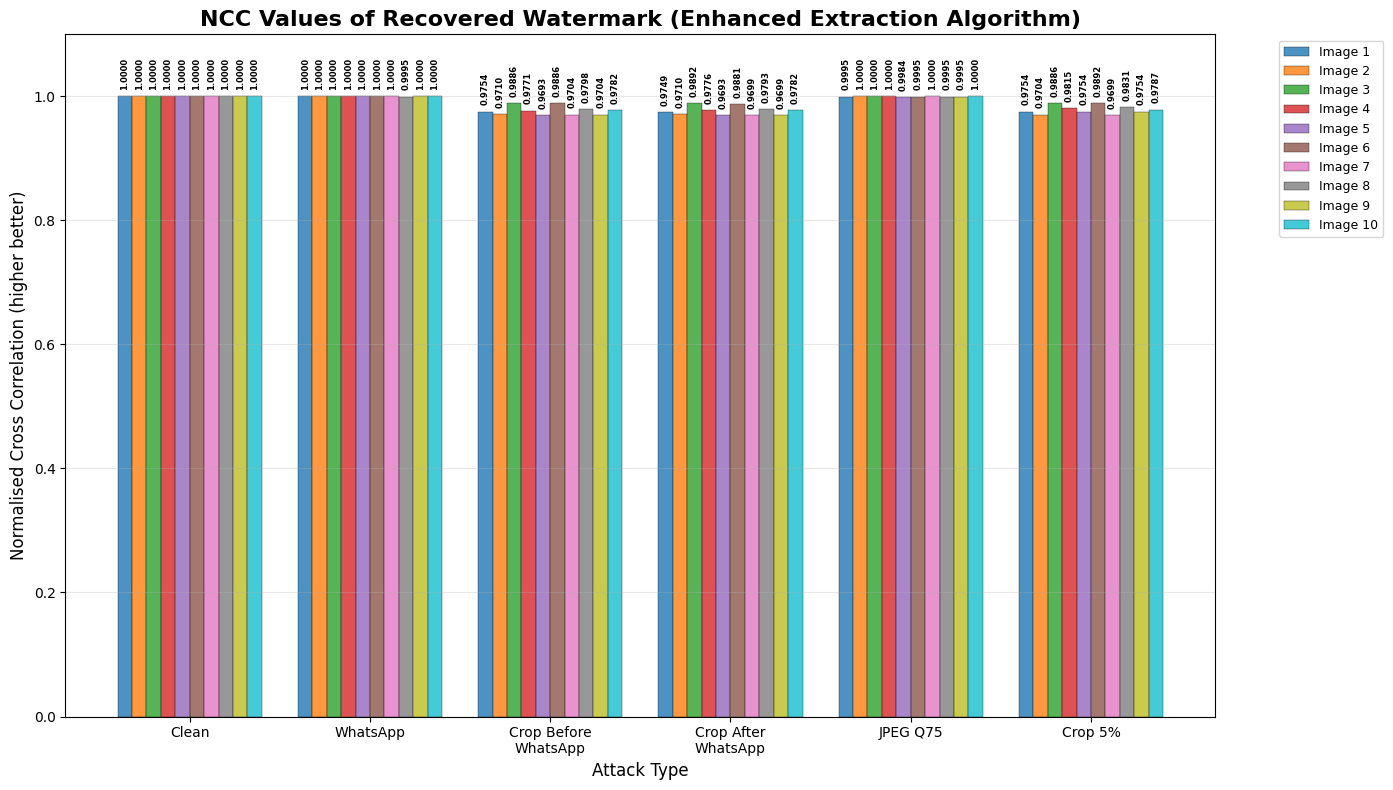

In [27]:
# ==========================================
# Bar chart - NCC for clean, whatsapp, crop_before_cw, crop_after_cw, jpeg, crop with all 10 images (Enhanced extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'WhatsApp', 'Crop Before\nWhatsApp', 'Crop After\nWhatsApp', 'JPEG Q75', 'Crop 5%']
attack_keys = ['clean', 'whatsapp', 'after_cw', 'before_cw', 'jpeg', 'crop']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ncc_values_per_image = []
    for attack_key in attack_keys:
        ncc_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ncc_enh'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ncc_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on bars for low NCC values
    for bar, ncc_val in zip(bars, ncc_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ncc_val:.4f}', ha='center', va='bottom', fontsize=6, fontweight='bold',
                rotation=90)

plt.title('NCC Values of Recovered Watermark (Enhanced Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Normalised Cross Correlation (higher better)', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)  # Set y-axis limit for NCC values

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ncc_2obj_all_images_enh.png", dpi=300, bbox_inches='tight')
plt.show()

# PSNR (3rd Objective)

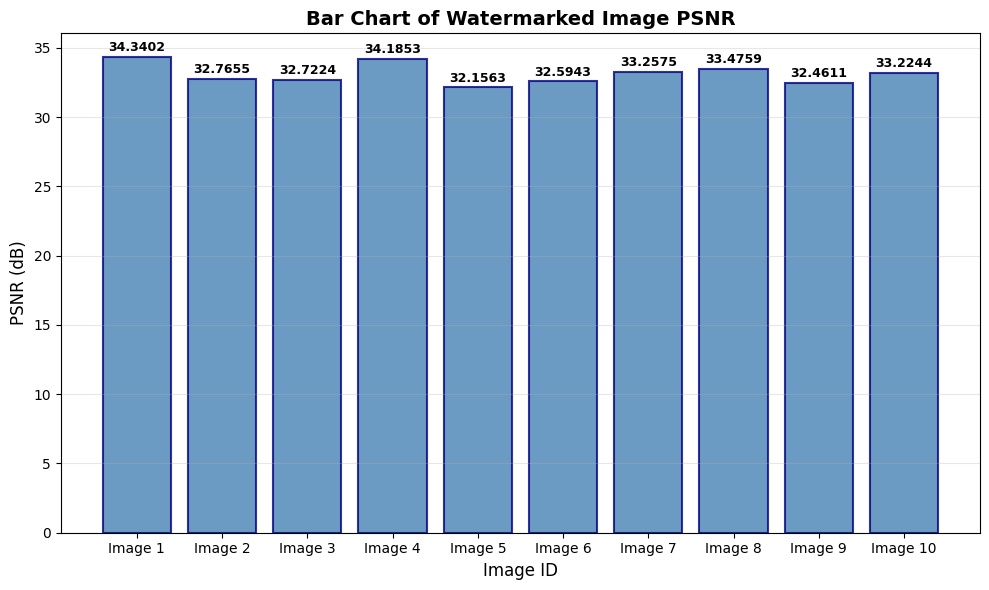

In [21]:
# ==========================================
# Watermarked PSNR Bar Chart
# ==========================================
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(all_results))
bars = plt.bar(x_pos, df['psnr_embed'], alpha=0.8, color='steelblue', edgecolor='navy', linewidth=1.5)
plt.title('Bar Chart of Watermarked Image PSNR', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.xticks(x_pos, [f'Image {i+1}' for i in range(len(all_results))])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, psnr in zip(bars, df['psnr_embed']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{psnr:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_watermarked_psnr_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# BER

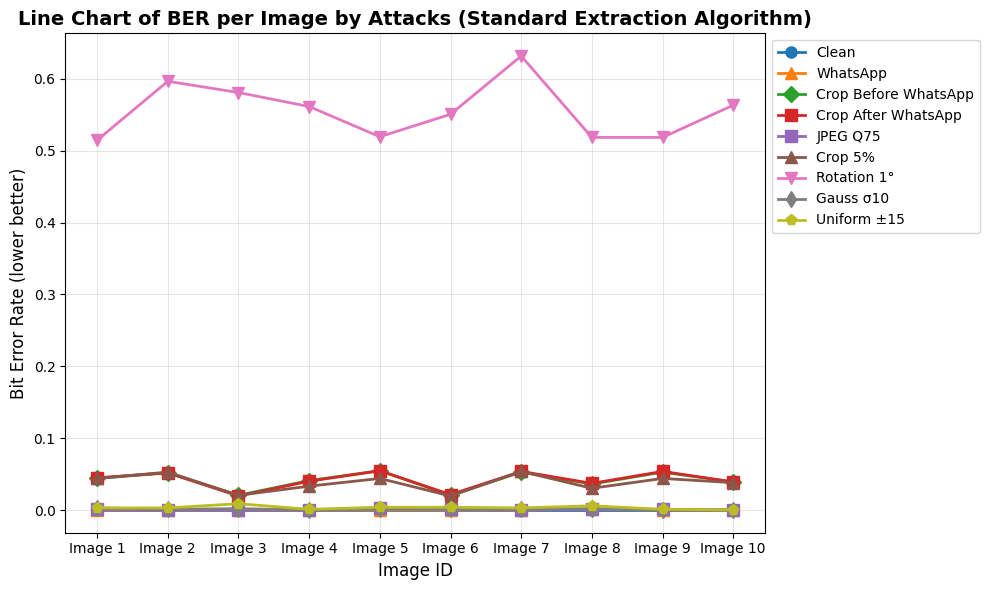

In [22]:
# ==========================================
# 4. Line chart - BER for each attack (Standard extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)
x_labels = [f'Image {i}' for i in x]

plt.plot(x, df['clean_ber_std'], 'o-', linewidth=2, markersize=8, label='Clean')
plt.plot(x, df['whatsapp_ber_std'], '^-', linewidth=2, markersize=8, label='WhatsApp')
plt.plot(x, df['after_cw_ber_std'], 'D-', linewidth=2, markersize=8, label='Crop Before WhatsApp')
plt.plot(x, df['before_cw_ber_std'], 's-', linewidth=2, markersize=8, label='Crop After WhatsApp')
plt.plot(x, df['jpeg_ber_std'], 's-', linewidth=2, markersize=8, label='JPEG Q75')
plt.plot(x, df['crop_ber_std'], '^-', linewidth=2, markersize=8, label='Crop 5%')
plt.plot(x, df['rot_ber_std'], 'v-', linewidth=2, markersize=8, label='Rotation 1°')
plt.plot(x, df['gauss_ber_std'], 'd-', linewidth=2, markersize=8, label='Gauss σ10')
plt.plot(x, df['uniform_ber_std'], 'p-', linewidth=2, markersize=8, label='Uniform ±15')

plt.title('Line Chart of BER per Image by Attacks (Standard Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Bit Error Rate (lower better)', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(x, x_labels)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ber_line_chart_std.png", dpi=300, bbox_inches='tight')
plt.show()

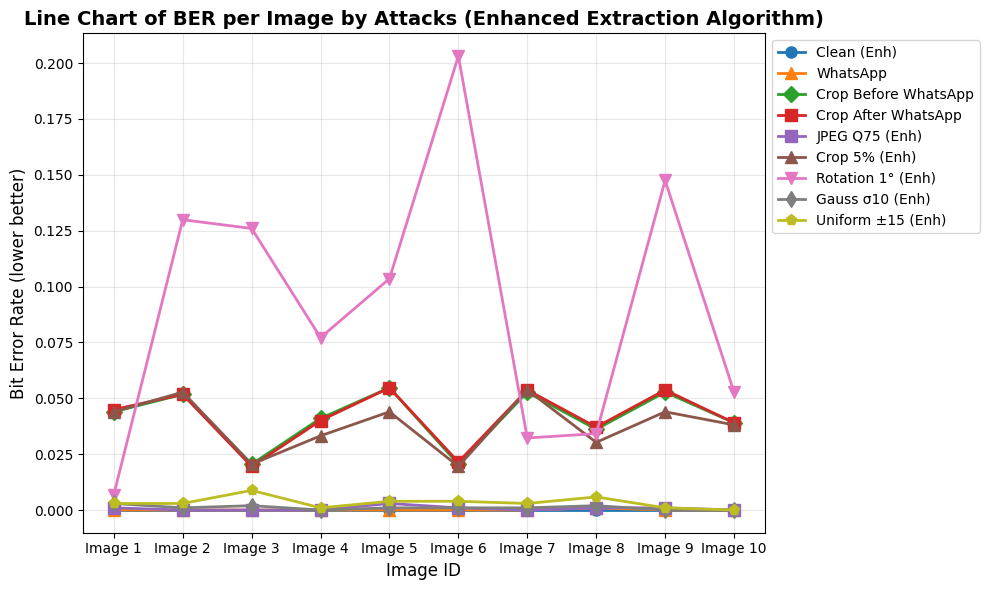

In [23]:
# ==========================================
# 4. Line chart - BER for each attack (Enhanced extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)
x_labels = [f'Image {i}' for i in x]

plt.plot(x, df['clean_ber_enh'], 'o-', linewidth=2, markersize=8, label='Clean (Enh)')
plt.plot(x, df['whatsapp_ber_enh'], '^-', linewidth=2, markersize=8, label='WhatsApp')
plt.plot(x, df['after_cw_ber_enh'], 'D-', linewidth=2, markersize=8, label='Crop Before WhatsApp')
plt.plot(x, df['before_cw_ber_enh'], 's-', linewidth=2, markersize=8, label='Crop After WhatsApp')
plt.plot(x, df['jpeg_ber_enh'], 's-', linewidth=2, markersize=8, label='JPEG Q75 (Enh)')
plt.plot(x, df['crop_ber_enh'], '^-', linewidth=2, markersize=8, label='Crop 5% (Enh)')
plt.plot(x, df['rot_ber_enh'], 'v-', linewidth=2, markersize=8, label='Rotation 1° (Enh)')
plt.plot(x, df['gauss_ber_enh'], 'd-', linewidth=2, markersize=8, label='Gauss σ10 (Enh)')
plt.plot(x, df['uniform_ber_enh'], 'p-', linewidth=2, markersize=8, label='Uniform ±15 (Enh)')

plt.title('Line Chart of BER per Image by Attacks (Enhanced Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Bit Error Rate (lower better)', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(x, x_labels)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ber_line_chart_enh.png", dpi=300, bbox_inches='tight')
plt.show()

# NCC

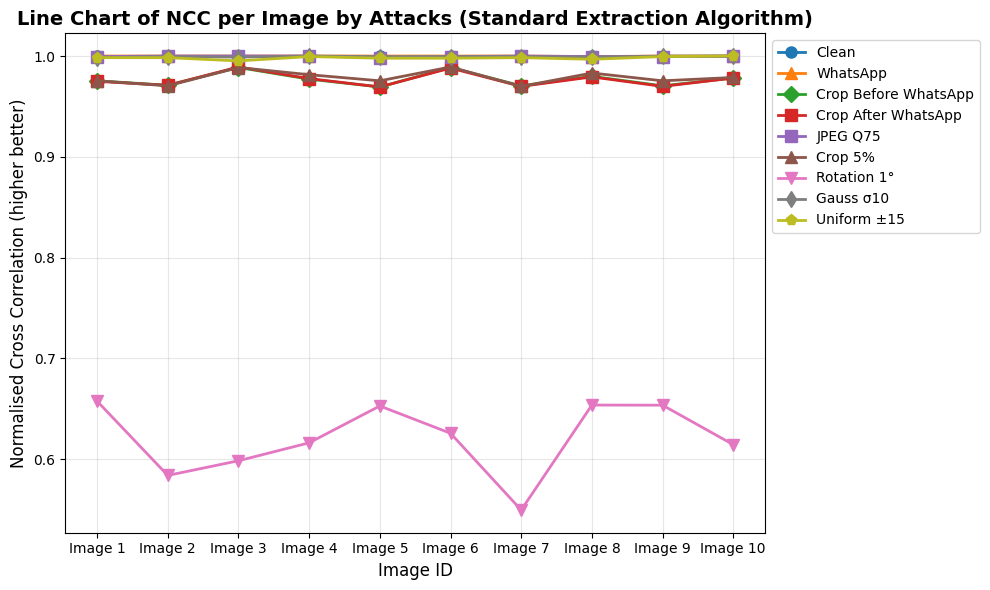

In [24]:
# ==========================================
# Line chart - NCC for each attack (standard extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))

plt.plot(x, df['clean_ncc_std'], 'o-', linewidth=2, markersize=8, label='Clean')
plt.plot(x, df['whatsapp_ncc_std'], '^-', linewidth=2, markersize=8, label='WhatsApp')
plt.plot(x, df['after_cw_ncc_std'], 'D-', linewidth=2, markersize=8, label='Crop Before WhatsApp')
plt.plot(x, df['before_cw_ncc_std'], 's-', linewidth=2, markersize=8, label='Crop After WhatsApp')
plt.plot(x, df['jpeg_ncc_std'], 's-', linewidth=2, markersize=8, label='JPEG Q75')
plt.plot(x, df['crop_ncc_std'], '^-', linewidth=2, markersize=8, label='Crop 5%')
plt.plot(x, df['rot_ncc_std'], 'v-', linewidth=2, markersize=8, label='Rotation 1°')
plt.plot(x, df['gauss_ncc_std'], 'd-', linewidth=2, markersize=8, label='Gauss σ10')
plt.plot(x, df['uniform_ncc_std'], 'p-', linewidth=2, markersize=8, label='Uniform ±15')

plt.title('Line Chart of NCC per Image by Attacks (Standard Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Normalised Cross Correlation (higher better)', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(x, x_labels)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ncc_line_chart_std.png", dpi=300, bbox_inches='tight')
plt.show()

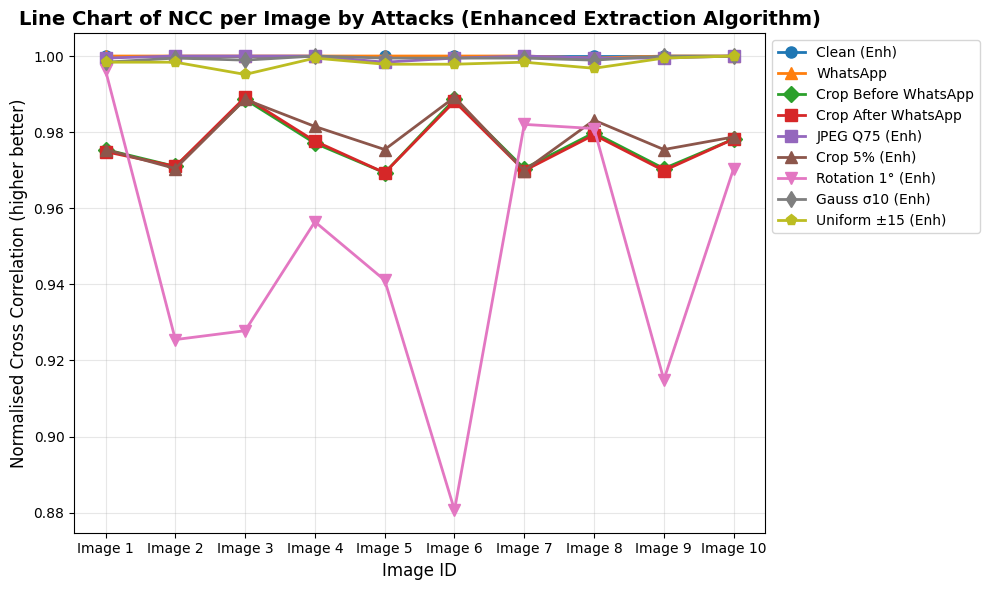

In [25]:
# ==========================================
# Line chart - NCC for each attack (enhanced extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)

plt.plot(x, df['clean_ncc_enh'], 'o-', linewidth=2, markersize=8, label='Clean (Enh)')
plt.plot(x, df['whatsapp_ncc_enh'], '^-', linewidth=2, markersize=8, label='WhatsApp')
plt.plot(x, df['after_cw_ncc_enh'], 'D-', linewidth=2, markersize=8, label='Crop Before WhatsApp')
plt.plot(x, df['before_cw_ncc_enh'], 's-', linewidth=2, markersize=8, label='Crop After WhatsApp')
plt.plot(x, df['jpeg_ncc_enh'], 's-', linewidth=2, markersize=8, label='JPEG Q75 (Enh)')
plt.plot(x, df['crop_ncc_enh'], '^-', linewidth=2, markersize=8, label='Crop 5% (Enh)')
plt.plot(x, df['rot_ncc_enh'], 'v-', linewidth=2, markersize=8, label='Rotation 1° (Enh)')
plt.plot(x, df['gauss_ncc_enh'], 'd-', linewidth=2, markersize=8, label='Gauss σ10 (Enh)')
plt.plot(x, df['uniform_ncc_enh'], 'p-', linewidth=2, markersize=8, label='Uniform ±15 (Enh)')

plt.title('Line Chart of NCC per Image by Attacks (Enhanced Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Normalised Cross Correlation (higher better)', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(x, x_labels)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}_ncc_line_chart_enh.png", dpi=300, bbox_inches='tight')
plt.show()